# Laboratorio 8
## Security Data Science
## Universidad del Valle de Guatemala

Andrés de la Roca - 20332

### Primera Parte - Creacion de la red neuronal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.python.client import device_lib

In [42]:
tf.compat.v1.disable_eager_execution()

In [2]:
path = './malimg_paper_dataset_imgs/'

In [3]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [7]:
familias.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [4]:
imgs, labels = next(familias)

In [9]:
imgs.shape

(9339, 64, 64, 3)

In [10]:
labels.shape

(9339, 25)

In [5]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

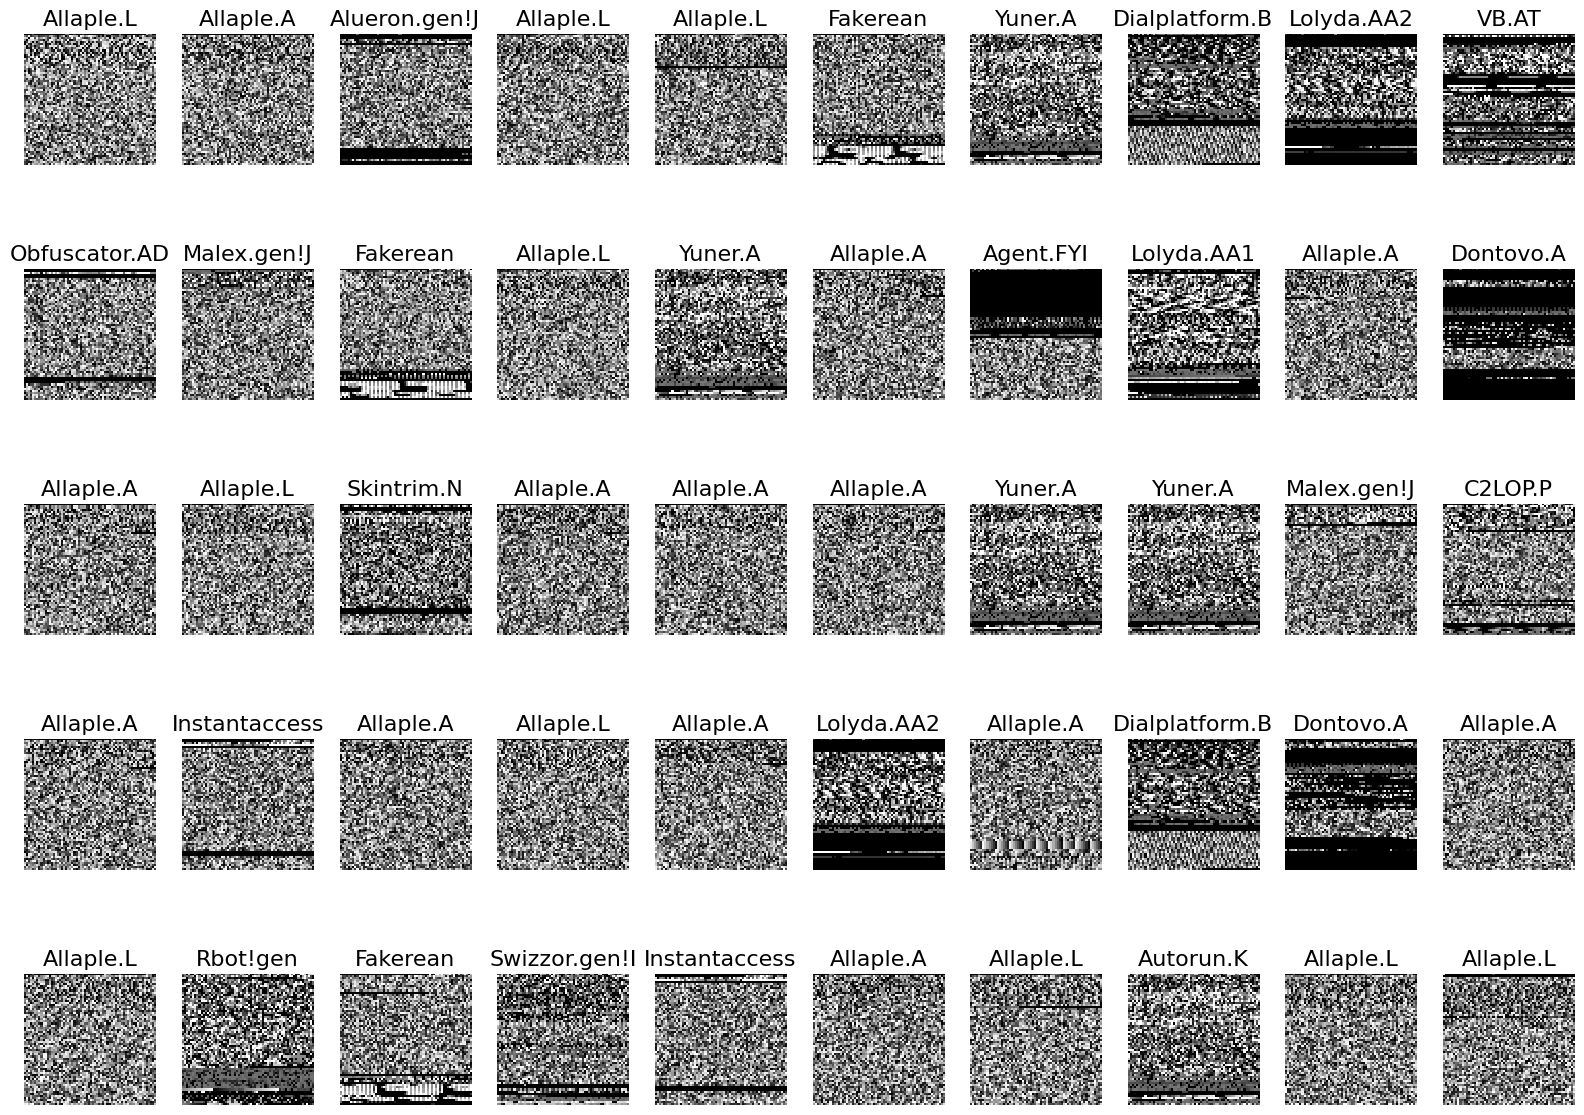

In [6]:

plots(imgs, titles = labels)

In [7]:
# 70% training, 30% testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=42)

X_train.shape

(6537, 64, 64, 3)

In [11]:
# Funciones de graficación
def plot_loss(history): # Funcion para graficar la perdida
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.legend()
  plt.show()

def plot_accuracy(history): # Funcion para graficar la precision
  plt.plot(history.history['accuracy'], label='train acc')
  plt.plot(history.history['val_accuracy'], label='val acc')
  plt.legend()
  plt.show()

In [32]:
# Modelo para clasificacion de imagenes de malware
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam

epochs = 5 # Numero de epocas

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(25, activation='softmax'))
# opt = Adam(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="adam")


In [33]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Train on 6537 samples, validate on 2802 samples
Epoch 1/5
6528/6537 [============================>.] - ETA: 0s - loss: 6.1656 - accuracy: 0.6330

c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6537/6537 [==============================] - 15s 2ms/sample - loss: 6.1587 - accuracy: 0.6332 - val_loss: 0.7886 - val_accuracy: 0.7595
Epoch 2/5
6537/6537 [==============================] - 12s 2ms/sample - loss: 0.4973 - accuracy: 0.8561 - val_loss: 0.5840 - val_accuracy: 0.8116
Epoch 3/5
6537/6537 [==============================] - 11s 2ms/sample - loss: 0.3427 - accuracy: 0.9038 - val_loss: 0.3605 - val_accuracy: 0.9097
Epoch 4/5
6537/6537 [==============================] - 11s 2ms/sample - loss: 0.1828 - accuracy: 0.9486 - val_loss: 0.3816 - val_accuracy: 0.9226
Epoch 5/5
6537/6537 [==============================] - 11s 2ms/sample - loss: 0.1279 - accuracy: 0.9657 - val_loss: 0.4044 - val_accuracy: 0.8972


In [34]:
original_classifier = KerasClassifier(model, clip_values=(0, 1))

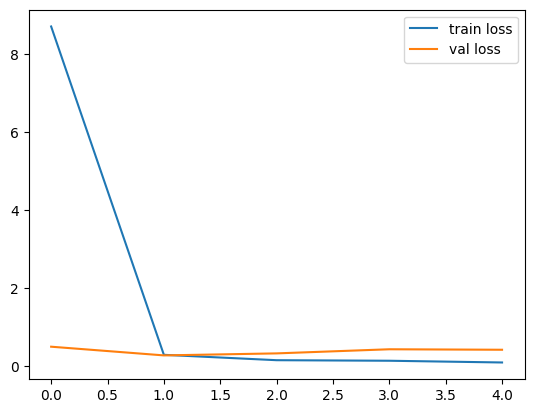

In [14]:
plot_loss(history)

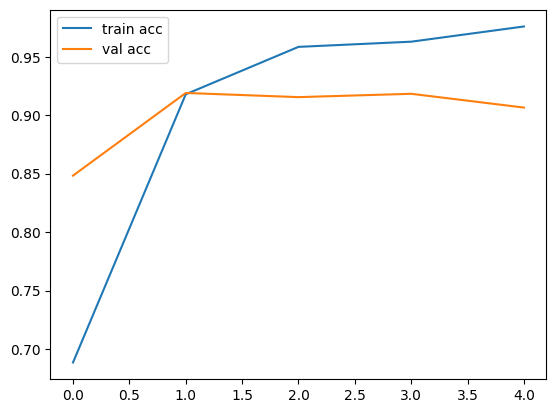

In [15]:
plot_accuracy(history)

In [16]:
results = model.evaluate(X_test, y_test)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

Loss:  0.4099144516014185
Accuracy:  0.90649533


In [25]:
# Guardar el modelo
model.save('modelo_malimg.h5')
# model.save('modelo_malimg.keras')

### Segunda Parte - Ataque a modelos

#### Ataque #1 Evasion

In [18]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

tf.compat.v1.disable_eager_execution()

c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [19]:
vulnerable_model = KerasClassifier(model=model)
# vulnerable_model = tf.keras.models.load_model('modelo_malimg.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                8

c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


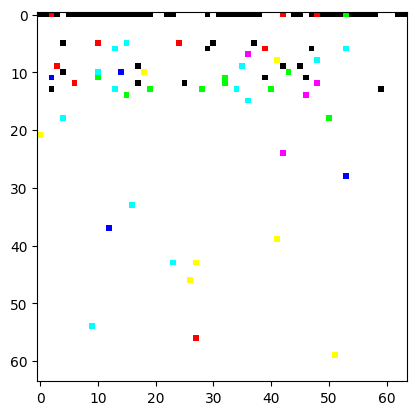

In [20]:
attack_fgsm = FastGradientMethod(estimator=vulnerable_model, eps=1)
test_images_adv = attack_fgsm.generate(X_test)
plt.imshow(test_images_adv[0])

In [21]:
# Evaluacion del modelo con ataques adversarios
results = vulnerable_model.predict(X_test)
accuracy = np.sum(np.argmax(results, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on clean test examples: {}%".format(accuracy * 100))

results_adv = vulnerable_model.predict(test_images_adv)
accuracy_adv = np.sum(np.argmax(results_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Accuracy on clean test examples: 90.64953604568166%
Accuracy on adversarial test examples: 68.91506067094933%


Explicacion de ataque  
Los ataques adversariales por medio del metodo de gradiente rapido son utilizadas para generar imagenes adversariales, funciona aprovechando la informacion de los gradientes del modelo con respecto a la entrada que acepta.  
Este metodo genera perturbaciones en las imagenes originales de tal manera que se logre engañar al modelo, haciendo que clasifique la imagen perturbada como una clase incorrecta.  
En el ataque realizado se puede observar que mientras mas se aumente epsilon, la imagen generara mayores perturbaciones, lo que por un lado disminuira la precision del modelo, pero por otro lado, se podra observar que la imagen perturbada se vera mas distorsionada a simple vista. En este caso se utilizo un valor de epsilon alto para ejemplificar esta perturbacion y se puede observar como la imagen perturbada esta muy distorsionada y como esto afecta la precision del modelo.

Este tipo de ataques pueden ser preocupantes porque pueden socavar la confianza en los sistemas de aprendizaje automatico, especialmente en aplicaciones criticas como la conduccion autonoma o el diagnostico medico. Ademas, revelan debilidades en la capacidad de los modelos de reconocer patrones "reales" y podrian tener implicaciones eticas y de seguridad significativas.

#### Ataque #2 Extraccion de modelo

In [38]:
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets

attack_catalogue = {
    "CopycatCNN": CopycatCNN(
        classifier=original_classifier,
        nb_epochs=epochs,
        nb_stolen=3000,
        use_probability=True,
    ),
    "Argmax CopycatCNN": CopycatCNN(
        classifier=original_classifier,
        nb_epochs=epochs,
        nb_stolen=3000,
        use_probability=False,
    ),
    "KnockoffNets": KnockoffNets(
        classifier=original_classifier,
        nb_epochs=epochs,
        nb_stolen=3000,
        use_probability=True,
    ),
    "Argmax KnockoffNets": KnockoffNets(
        classifier=original_classifier,
        nb_epochs=epochs,
        nb_stolen=3000,
        use_probability=False,
    ),
    
}

results = []

for attack_name, attack in attack_catalogue.items():
    model_stolen = model
    classifier_stolen = KerasClassifier(model=model_stolen)
    classifier_stolen = attack.extract(X_test, thieved_classifier=classifier_stolen)
    acc = classifier_stolen._model.evaluate(X_test, y_test)[1]
    results.append((attack_name, acc))
    print(f"Attack: {attack_name}\tAccuracy: {acc}")

results

Attack: CopycatCNN	Accuracy: 0.6220556497573853
Attack: Argmax CopycatCNN	Accuracy: 0.6152747869491577
Attack: KnockoffNets	Accuracy: 0.6034975051879883
Attack: Argmax KnockoffNets	Accuracy: 0.5931477546691895


[('CopycatCNN', 0.62205565),
 ('Argmax CopycatCNN', 0.6152748),
 ('KnockoffNets', 0.6034975),
 ('Argmax KnockoffNets', 0.59314775)]

Explicacion de ataque:  
Los ataques basados en la extraccion de modelos son utilizados para obtener informacion sobre el modelo entrenado, como los pesos, arquitectura, hiperparametros, etc. En este caso, se utilizo un ataque basado en la extraccion de modelos para obtener informacion sobre el modelo entrenado en la primera parte del laboratorio. El objetivo principal de estos ataques es obtener informacion sobre el modelo entrenado para poder replicarlo o utilizarlo de manera maliciosa. En este caso se enfoco en utilizar el modelo de tal manera que se pudieran realizar predicciones propias, sin embargo, debido a la naturaleza de las tecnicas utilizadas se obtuvieron resultados con una precision baja comparados a las metricas originales del modelo.

Uno de los dos metodos de ataques utilizados fueron las CopycatCNN el cual implica el imitar el comportamiento de otro modelo objetivo. Su objetivo principal es obtener un modelo que se comporte como el original, utilizando datos de estrada y salida generados por el modelo original. Esto puede plantear problemas de seguridad y privacidad, ya que un atacante puede usar el modelo copiado para realizar tareas para beneficio propio, potencialmente comprometiendo propiedad intelectual y/o confidencialidad de los datos de entrenamiento

El KnockoffNets, que fue el otro metodo, el objetivo es entrenar una red neuronal para imitar un moelo objetivo, pero en lugar de generar datos de entrada y salida, el atacante utiliza muestras de entrenamiento y predicciones del modelo objetivo. El proposito es replicar la funcion del modelo iriginal sin acceder a los datos de entrenamiento originales. En terminos generales es bastante similar al metodo anterior.

### Defensa contra Evasion


In [18]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer

tf.compat.v1.disable_eager_execution()

defended_model = Sequential()
defended_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
defended_model.add(MaxPooling2D((2, 2)))
defended_model.add(Conv2D(64, (3, 3), activation='relu'))
defended_model.add(MaxPooling2D((2, 2)))
defended_model.add(Flatten())
defended_model.add(Dense(64, activation='relu'))
defended_model.add(Dense(25, activation='softmax'))
defended_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer="adam")

defended_classifier = KerasClassifier(model=defended_model)

defended_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 12544)             0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [26]:
attacks = FastGradientMethod(estimator=defended_classifier, eps=1)

trainer = AdversarialTrainer(classifier=defended_classifier, attacks=attacks, ratio=0.5)
trainer.fit(X_train, y_train, batch_size=32, nb_epochs=5)

trainer.classifier.model.save('modelo_malimg_def.h5')

results = defended_classifier.predict(X_test)
accuracy = np.sum(np.argmax(results, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on clean test examples: {}%".format(accuracy * 100))


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Accuracy on clean test examples: 94.3254817987152%


In [27]:
test_images_adv = attacks.generate(X_test)

results_adv = defended_classifier.predict(test_images_adv)
accuracy_adv = np.sum(np.argmax(results_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Accuracy on adversarial test examples: 92.11277658815132%


Explicacion de defensa:  
En este caso se utilizo un metodo de defensa contra ataques adversariales mediante la inclusion de imagenes adversariales en el conjunto de entrenamiento. Este metodo se basa en la idea de entrenar un modelo adversarial que pueda generar perturbaciones adversariales y luego entrenar el modelo original con las imagenes perturbadas. De esta manera, el modelo original aprende a reconocer las perturbaciones adversariales y se vuelve mas robusto contra futuros ataques adversariales.

Como se logra observar en el resultado de la defensa, la precision del modelo mejora un 26%, una mejora significativa, lo que indica que el modelo es mas robusto contra ataques adversariales de evasion. Sin embargo, es importante tener en cuenta que este metodo no es infalible y que los atacantes pueden encontrar formas de evadir la defensa. Por lo tanto, es importante tener un desarrollo continuo de tecnicas de defensa para garantizar la seguridad completa del modelo.

### Defensa contra Extraccion de modelo

In [39]:
from art.defences.postprocessor import ReverseSigmoid
postprocessor = ReverseSigmoid(beta = 1.0, gamma=0.3)
defended_classifier = KerasClassifier(model=defended_model, postprocessing_defences=postprocessor)

attack_catalogue = {
    "CopycatCNN vs. Protected": CopycatCNN(
        classifier=defended_classifier,
        nb_epochs=epochs,
        nb_stolen=3000,
        use_probability=True,
    ),
    "Argmax CopycatCNN vs. Protected": CopycatCNN(
        classifier=defended_classifier,
        nb_epochs=epochs,
        nb_stolen=3000,
        use_probability=False,
    ),
    "KnockoffNets vs. Protected": KnockoffNets(
        classifier=defended_classifier,
        nb_epochs=epochs,
        nb_stolen=3000,
        use_probability=True,
    ),
    "Argmax KnockoffNets vs. Protected": KnockoffNets(
        classifier=defended_classifier,
        nb_epochs=epochs,
        nb_stolen=3000,
        use_probability=False,
    ),
}

results = []

for attack_name, attack in attack_catalogue.items():
    model_stolen = model
    classifier_stolen = KerasClassifier(model=model_stolen)
    classifier_stolen = attack.extract(X_test, thieved_classifier=classifier_stolen)
    acc = classifier_stolen._model.evaluate(X_test, y_test)[1]
    results.append((attack_name, acc))
    print(f"Attack: {attack_name}\tAccuracy: {acc}")

c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\art\defences\postprocessor\reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)


Attack: CopycatCNN vs. Protected	Accuracy: 0.17130620777606964
Attack: Argmax CopycatCNN vs. Protected	Accuracy: 0.30620986223220825
Attack: KnockoffNets vs. Protected	Accuracy: 0.08386866748332977
Attack: Argmax KnockoffNets vs. Protected	Accuracy: 0.30620986223220825


Explicacion de defensa:  
Para poder realizar una defensa contra ataques de extraccion se puede realizar algun tipo de perturbacion a la salida del modelo, de tal manera que el atacante no pueda obtener informacion totalmente legible del modelo, de esta forma su modelo sera bastante deficiente en cuanto a precision comparado con el original. 
En esta ocasion se utiliza la estrategia de utilizar la funcion reverse sigmoid, que en esencia, transforma las predicciones del modelo mediante la funcion inversa sigmoide, lo que puede dificultar la inferencia de informacion sobre el modelo original.

Los parametros beta y gamma controlan la forma especifica de esta perturbacion, la integracion con el modelo es bastante simple y puede ayudar a mitigar los riesgos asociados con ataques de extraccion. 

Se puede observar en las metricas de rendimiento, los modelos copiados ahora tienen una precision deficiente comparada con el modelo original, llegando hasta incluso tener un 8% de precision en el caso de KnockoffNets basado de resultados probabilisticos, lo que indica que la defensa ha sido efectiva. 

Vale la pena mencionar que existen varios metodos de defensa aplicables a este caso que en un futuro podrian ser implementados, principalmente ofuscadores en la forma de postprocesadores de modelos, entre ellos, el postprocesamiento basado en ruido gaussiano, postprocesamiento basado en confianza alta, postprocesamiento basado en el redondeo de la salida del modelo, entre otros.